# Continuous Attractor Neural Network with STP  
## The dynamics of CANN with STP  
### Synaptic current dynamics (short-term plasticity variable $g,h$ are added to the model):  
$$  
\tau \frac{dU(x,t)}{dt} = -U(x,t)+ \int g^+(x')*h(x',t)J(x,x')r(x',t)dx' + I^{ext} - V(x,t)  
$$  
### STP dynamics (modeling the available fraction and release probability of neuro-transmitter):  
$$  
\tau \frac{dg(x,t)}{dt} = -\frac{g(x,t)}{\tau_f}+ G(1-g^-(x))r(x,t)  
$$  
$$  
\tau \frac{dh(x,t)}{dt} = \frac{1-h(x,t)}{\tau_d}+ g^+(x)h(x,t)r(x,t)  
$$  
$$  
g^+(x,t) = g(x,t) + G*[1-g(x,t)]  
$$  
## 1. Customize a CANN with STP

In [29]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 15})
plt.rcParams['font.sans-serif'] = ['Times New Roman']


class CANN1D_STP(bp.NeuGroupNS):
  def __init__(self, num, tau=1., tau_f=1., tau_d=30., G=0.2, k=8.1, a=0.5, A=10., J0=12.,
               z_min=-bm.pi, z_max=bm.pi, **kwargs):
    super(CANN1D_STP, self).__init__(size=num, **kwargs)

    # 初始化参数
    self.tau = tau
    # TO DO: time constants of g and h
    self.tau_f = ???
    self.tau_d = ???
      
    self.G = G
    self.k = k
    self.a = a
    self.A = A
    self.J0 = J0
      
    # 初始化特征空间相关参数
    self.z_min = z_min
    self.z_max = z_max
    self.z_range = z_max - z_min
    self.x = bm.linspace(z_min, z_max, num)
    self.rho = num / self.z_range
    self.dx = self.z_range / num

    # 初始化变量
    self.u = bm.Variable(bm.zeros(num))
    # TO DO: 初始化 g 和 h
    self.g =  #neuro-transmitter release probability
    self.h =  #neuro-transmitter available fraction
      
    self.input = bm.Variable(bm.zeros(num))
    self.conn_mat = self.make_conn(self.x)  # 连接矩阵

    # 定义积分函数
    self.integral = bp.odeint(self.derivative)

  # 根据模型的微分方程构建导数函数
  @property
  def derivative(self):
    du = ???
    dg = ???
    dh = ???
    return bp.JointEq([du, dg, dh])

  # 将距离转换到[-z_range/2, z_range/2)之间
  def dist(self, d):
    d = bm.remainder(d, self.z_range)
    d = bm.where(d > 0.5 * self.z_range, d - self.z_range, d)
    return d

  # 计算连接矩阵
  def make_conn(self, x):
    assert bm.ndim(x) == 1
    d = self.dist(x - x[:, None])  # 距离矩阵
    Jxx = self.J0 * bm.exp(
      -0.5 * bm.square(d / self.a)) / (bm.sqrt(2 * bm.pi) * self.a) 
    return Jxx

  # 获取各个神经元到pos处神经元的输入
  def get_stimulus_by_pos(self, pos):
    return self.A * bm.exp(-0.25 * bm.square(self.dist(self.x - pos) / self.a))

  def update(self, x=None):
    u2 = bm.square(self.u)
    r = u2 / (1.0 + self.k * bm.sum(u2)) 
    # TO DO: 计算在引入了STP之后的recurrent input并更新模型状态
    Irec = ???
    u, g, h = self.integral()
    self.u[:] = bm.where(u>0,u,0)
    self.g.value = g
    self.h.value = h
    self.input[:] = 0.  # 重置外部电流

## 答案见课件  
## 2. Simulate traveling wave in CANN with STP  
To do: 调整参数，看看什么参数会影响波包是否移动的条件，以及波包移动的速度

  0%|          | 0/10000 [00:00<?, ?it/s]

134


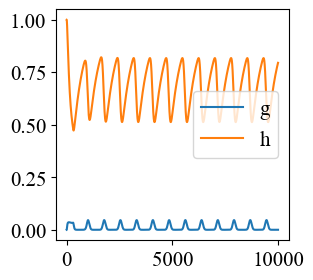

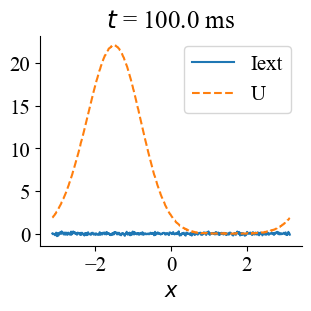

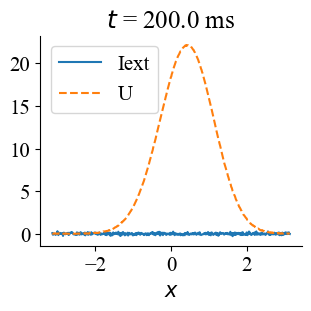

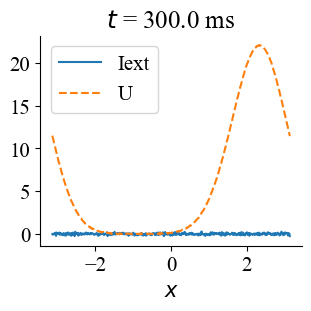

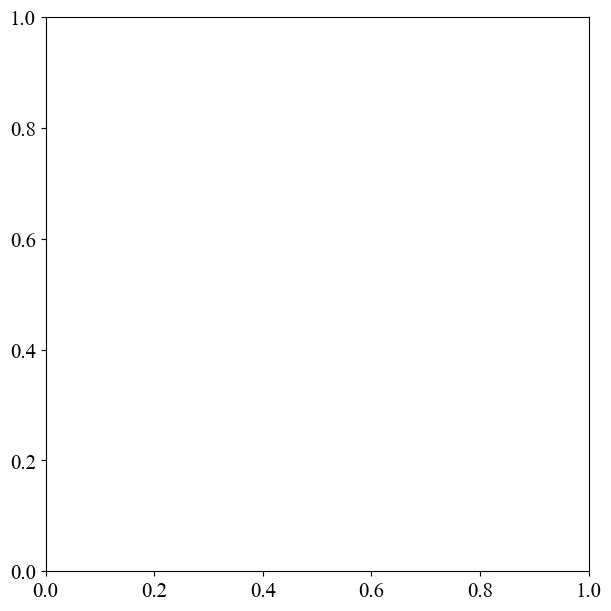

In [32]:
import numpy as np
def traveling_wave_STP(num=512,k=0.1,J0=12.,tau_d=1000,tau_f=1.,G=0.9):
    # 生成CANN
    cann_stp = CANN1D_STP(num=num, k=k,tau_d=tau_d,tau_f=tau_f,G=G, J0=J0)

    # 生成外部刺激
    dur = 1000.
    noise_level = 0.1
    Iext = bm.random.normal(0., noise_level, (int(dur / bm.get_dt()), num))
    duration = dur
    # 运行数值模拟
    runner = bp.DSRunner(cann_stp, inputs=['input', Iext, 'iter'], monitors=['u','g','h'])
    runner.run(duration)
    fig,ax = plt.subplots(figsize=(3,3))
    u = bm.as_numpy(runner.mon.u)
    max_index = np.argmax(u[1000,:])
    print(max_index)
    ax.plot(runner.mon.g[:,max_index],label='g')
    ax.plot(runner.mon.h[:,max_index],label='h')
    ax.legend()
    # 可视化
    def plot_response(t):
        fig, gs = bp.visualize.get_figure(1, 1, 3, 3)
        ax = fig.add_subplot(gs[0, 0])
        ts = int(t / bm.get_dt())
        I, u = Iext[ts], runner.mon.u[ts]
        ax.plot(cann_stp.x, I, label='Iext')
        ax.plot(cann_stp.x, u, linestyle='dashed', label='U')
        ax.set_title(r'$t$' + ' = {} ms'.format(t))
        ax.set_xlabel(r'$x$')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.legend()
    plot_response(t=100.)
    plot_response(t=200.)
    plot_response(t=300.)

    bp.visualize.animate_1D(
        dynamical_vars=[{'ys': runner.mon.u, 'xs': cann_stp.x, 'legend': 'u'},
                        {'ys': Iext, 'xs': cann_stp.x, 'legend': 'Iext'}],
        frame_step=1,
        frame_delay=40,
        show=True,
    )
    plt.show()
    
traveling_wave_STP(G=0.5,tau_d=50)